# 🏃🏼‍♂️ FastHerbie

Often, data from several GRIB2 files is needed (range of datetimes and/or forecast lead time). `FastHerbie()` use multithreading to help you efficiently create multiple Herbie objects. Then you can download many files using multiprocessing. When you open the data with xarray, it will concatenate the DataSets for a range of model runs and forecast lead times.

In this example, we will get the F00-F05 forecasts for each of the runs initialized between 00z-06z on January 1, 2022 (a total of 36 Herbie objects).


In [1]:
from herbie import FastHerbie
import pandas as pd

In [2]:
# Create a range of dates
DATES = pd.date_range(
    start="2022-03-01 00:00",
    periods=6,
    freq="1h",
)

# Create a range of forecast lead times
fxx = list(range(0, 6))

DATES, fxx

(DatetimeIndex(['2022-03-01 00:00:00', '2022-03-01 01:00:00',
                '2022-03-01 02:00:00', '2022-03-01 03:00:00',
                '2022-03-01 04:00:00', '2022-03-01 05:00:00'],
               dtype='datetime64[ns]', freq='h'),
 [0, 1, 2, 3, 4, 5])

In [3]:
# Make FastHerbie Object.
FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
FH

At it's core, ``FastHerbie`` uses multithreading to make a list of Herbie objects. The list of Herbie objects is stored in the `objects` property.

In [4]:
FH.objects, len(FH.objects)

([▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 00:00 UTC F00 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 00:00 UTC F01 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 00:00 UTC F02 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 00:00 UTC F03 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 00:00 UTC F04 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 00:00 UTC F05 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 01:00 UTC F00 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 01:00 UTC F01 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 01:00 UTC F02 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 01:00 UTC F03 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar-01 01:00 UTC F04 ┊ source=aws,
  ▌▌Herbie HRRR model sfc product initialized 2022-Mar

You can download those Herbie objects as full files or subsets.

In [5]:
# Download full file
# (commented out because it would take a long time, but you get the idea)
# FH.download()

In [6]:
# Download subset
FH.download("TMP:2 m")

[PosixPath('/home/blaylock/data/hrrr/20220301/subset_51e4fd54__hrrr.t02z.wrfsfcf01.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_514bfd54__hrrr.t02z.wrfsfcf04.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_72effd54__hrrr.t01z.wrfsfcf00.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_b4effd54__hrrr.t03z.wrfsfcf00.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_9be4fd54__hrrr.t00z.wrfsfcf01.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_b4e4fd54__hrrr.t03z.wrfsfcf01.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_51effd54__hrrr.t02z.wrfsfcf00.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_9b21fd54__hrrr.t00z.wrfsfcf02.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_9b4bfd54__hrrr.t00z.wrfsfcf04.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_7221fd54__hrrr.t01z.wrfsfcf02.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20220301/subset_5121fd54__hrrr.t02z.wrfsfcf

You can also read the data with xarray. You'll see here that there are new dimensions for `step` and `time`.

In [7]:
ds = FH.xarray("TMP:2 m")
ds

/home/blaylock/GITHUB/Herbie/src/herbie/core.py:1257: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/home/blaylock/GITHUB/Herbie/src/herbie/core.py:1257: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/home/blaylock/GITHUB/Herbie/src/herbie/core.py:1257: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/home/blaylock/GITHUB/Herbie/src/herbie/core.py:1257: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/home/blaylock/GITHUB/Herbie/src/herbie/core.py:1257: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


<xarray.Dataset> Size: 305MB
Dimensions:              (step: 6, time: 6, y: 1059, x: 1799)
Coordinates:
  * step                 (step) timedelta64[ns] 48B 00:00:00 ... 05:00:00
  * time                 (time) datetime64[ns] 48B 2022-03-01 ... 2022-03-01T...
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           (step, time) datetime64[ns] 288B 2022-03-01 ... 2022...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (step, time, y, x) float32 274MB 292.7 292.7 ... 262.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    search:                  TMP:2 m

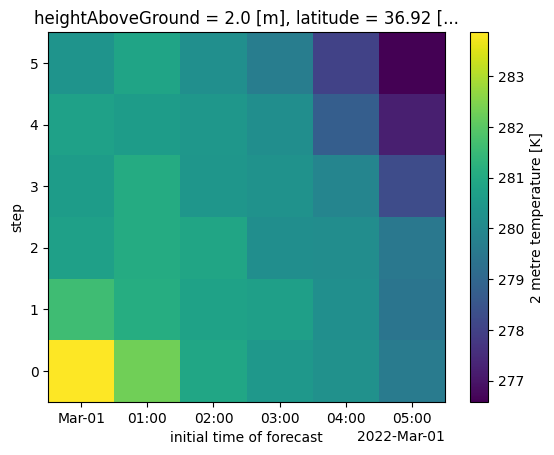

In [ ]:
# plot matrix at a single point
a = ds.isel(y=500, x=500)
a["step"] = a["step"].dt.total_seconds() / 3600  # have to convert to hours to plot
a.t2m.plot() # Note: Diagonals are the same valid time

If multiple hypercubes are returned by cfgrib when reading with xarray, then you still get a list of Datasets

In [9]:
FH.inventory("TMP:(?:[8,5]00 mb|2 m)")


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this,FILE
0,15,7631631,8193915.0,7631631-8193915,2022-03-01 00:00:00,2022-03-01 00:00:00,TMP,500 mb,anl,:TMP:500 mb:anl,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
1,71,36318346,37549890.0,36318346-37549890,2022-03-01 00:00:00,2022-03-01 00:00:00,TMP,2 m above ground,anl,:TMP:2 m above ground:anl,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
2,15,7635185,8203254.0,7635185-8203254,2022-03-01 00:00:00,2022-03-01 01:00:00,TMP,500 mb,1 hour fcst,:TMP:500 mb:1 hour fcst,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
3,71,43581050,44810228.0,43581050-44810228,2022-03-01 00:00:00,2022-03-01 01:00:00,TMP,2 m above ground,1 hour fcst,:TMP:2 m above ground:1 hour fcst,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
4,15,7962155,8519233.0,7962155-8519233,2022-03-01 00:00:00,2022-03-01 02:00:00,TMP,500 mb,2 hour fcst,:TMP:500 mb:2 hour fcst,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
...,...,...,...,...,...,...,...,...,...,...,...
67,71,44489436,45801367.0,44489436-45801367,2022-03-01 05:00:00,2022-03-01 08:00:00,TMP,2 m above ground,3 hour fcst,:TMP:2 m above ground:3 hour fcst,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
68,15,8192881,8752530.0,8192881-8752530,2022-03-01 05:00:00,2022-03-01 09:00:00,TMP,500 mb,4 hour fcst,:TMP:500 mb:4 hour fcst,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
69,71,44688940,46005220.0,44688940-46005220,2022-03-01 05:00:00,2022-03-01 09:00:00,TMP,2 m above ground,4 hour fcst,:TMP:2 m above ground:4 hour fcst,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...
70,15,8285779,8844677.0,8285779-8844677,2022-03-01 05:00:00,2022-03-01 10:00:00,TMP,500 mb,5 hour fcst,:TMP:500 mb:5 hour fcst,https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrr...


In [10]:
ds = FH.xarray("TMP:(?:[8,5]00 mb|2 m)", remove_grib=False)
len(ds)

/home/blaylock/GITHUB/Herbie/src/herbie/fast.py:347: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  ds = xr.combine_nested(
/home/blaylock/GITHUB/Herbie/src/herbie/fast.py:347: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  ds = xr.combine_nested(
/home/blaylock/GITHUB/Herbie/src/herbie/fast.py:347: FutureWarning: 

2

In [11]:
ds[0]

<xarray.Dataset> Size: 305MB
Dimensions:              (step: 6, time: 6, y: 1059, x: 1799)
Coordinates:
  * step                 (step) timedelta64[ns] 48B 00:00:00 ... 05:00:00
  * time                 (time) datetime64[ns] 48B 2022-03-01 ... 2022-03-01T...
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           (step, time) datetime64[ns] 288B 2022-03-01 ... 2022...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (step, time, y, x) float32 274MB 292.7 292.7 ... 262.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    search:                  TMP:(?:[8,5]00 mb|2 m)

In [12]:
ds[1]

<xarray.Dataset> Size: 305MB
Dimensions:              (step: 6, time: 6, y: 1059, x: 1799)
Coordinates:
  * step                 (step) timedelta64[ns] 48B 00:00:00 ... 05:00:00
  * time                 (time) datetime64[ns] 48B 2022-03-01 ... 2022-03-01T...
    isobaricInhPa        float64 8B 500.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           (step, time) datetime64[ns] 288B 2022-03-01 ... 2022...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t                    (step, time, y, x) float32 274MB 262.7 262.7 ... 238.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    search:                  TMP:(?:[8,5]00 mb|2 m)